In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
 
# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Reading The Dataset
file_path = r'C:\Users\sachi\Spam Email Identification Project Using AI\Datasets\Emails.csv'
data = pd.read_csv(file_path)
data.head()




,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
#Shape Of Data Frame
data.shape




(5728, 2)

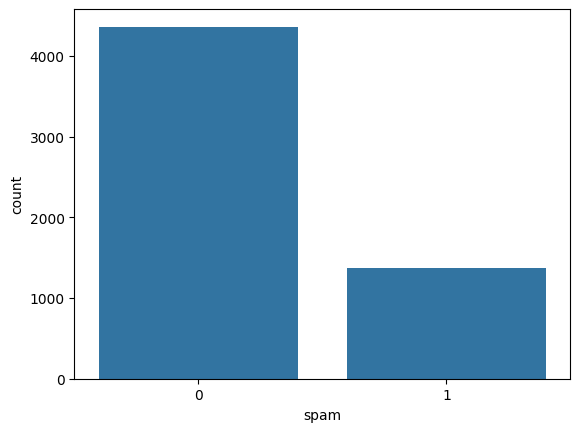

In [4]:
#Plotting Ham And Spam Using Seaborn
sns.countplot(x='spam', data=data)
plt.show()




In [5]:

#Now We Will Balance The Dataset


Text(0.5, 0, 'Message types')

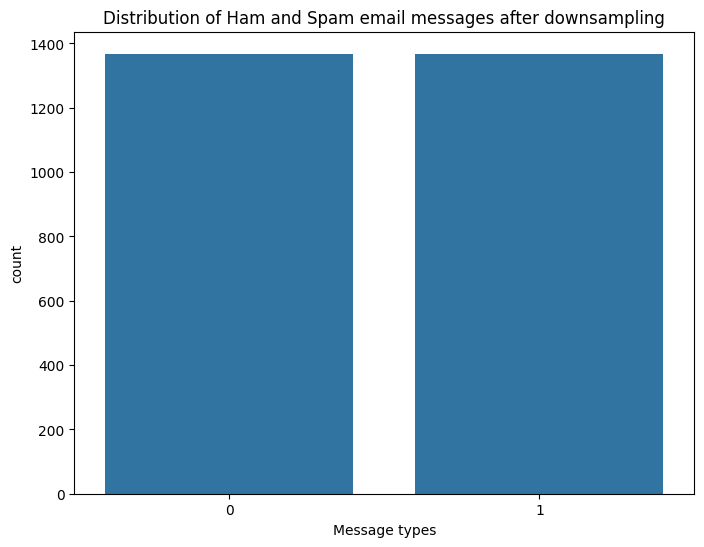

In [6]:


# Downsampling to balance the dataset
ham_msg = data[data.spam == 0]
spam_msg = data[data.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),
                         random_state=42)



 
# Plotting the counts of down sampled dataset
balanced_data = pd.concat([ham_msg, spam_msg]).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')




In [7]:
#Text Preprocessing
#Textual data is highly unstructured and need attention in many aspects:
#   Stopwords Removal
#   Punctuations Removal
#   Stemming or Lemmatization


#Removing Subject Word From Dataset
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()




,text,spam
0,: interview schedule for jinbaek kim i didn '...,0
1,": re : wednesday meeting eric , i think we c...",0
2,: re : london research group i ' d do it as s...,0
3,": re : congratulations vince , thanks for you...",0
4,: osman sezgen steve kromer is requesting tha...,0


In [8]:
#Removing Punctuations
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()




,text,spam
0,interview schedule for jinbaek kim i didn t...,0
1,re wednesday meeting eric i think we can ...,0
2,re london research group i d do it as soon...,0
3,re congratulations vince thanks for your n...,0
4,osman sezgen steve kromer is requesting that...,0


In [9]:
#Removing Stopwords
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()





,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


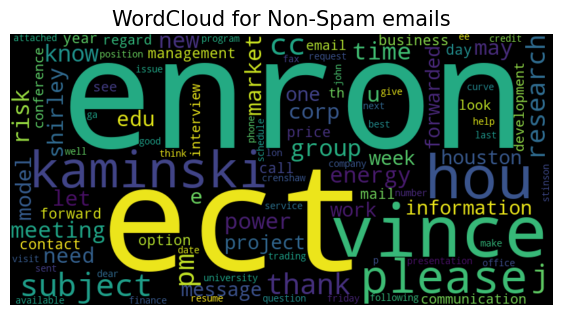

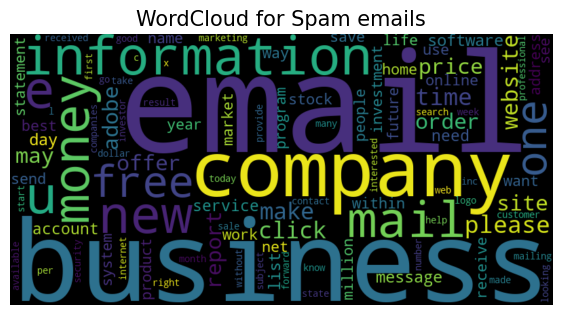

In [15]:
#Word Cloud
#WordCloud:A word cloud is a text visualization tool that help’s us to get insights into the most frequent words present in the corpus of the data.


def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')


In [16]:



#Word2Vec Conversion
#We cannot feed words to a machine learning model because they work on numbers only. So, first, we will convert our words to vectors with the token IDs to the corresponding words and after padding them our textual data will arrive to a stage where we can feed it to a model.
#Vector:Vector is a mathematical approach for expressing and organizing data. The vectorization of data, such as word vectorization, is one of the initial phases in the creation of an ML model. In natural language processing, Word2Vec is a well-known ML model




#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)





In [17]:
#Tokenizing:Tokenizing is the process of breaking a text or a sequence of characters into smaller units, known as tokens. In the context of natural language processing (NLP), tokens are usually words, phrases, symbols, or other meaningful elements that make up the text.



# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
 
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
 
# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len, 
                                padding='post', 
                                truncating='post')
test_sequences = pad_sequences(test_sequences, 
                               maxlen=max_len, 
                               padding='post', 
                               truncating='post')





In [18]:

"""Model Development and Evaluation
   :We will implement a Sequential model which will contain the following parts
        1.Three Embedding Layers to learn featured vector representations of the input vectors.
        2.An LSTM layer to identify useful patterns in the sequence.
        3.Then we will have one fully connected layer.
        4.The final layer is the output layer which outputs probabilities for the two classes."""




'Model Development and Evaluation\n   :We will implement a Sequential model which will contain the following parts\n        1.Three Embedding Layers to learn featured vector representations of the input vectors.\n        2.An LSTM layer to identify useful patterns in the sequence.\n        3.Then we will have one fully connected layer.\n        4.The final layer is the output layer which outputs probabilities for the two classes.'

In [19]:
#The Sequential Model:Sequential API is a slightly less refined API for modelling simpler neural networks. Each layer in the network accepts only one input and passes on a single output.  It is important to note that sequential models don’t work when the model requires multiple inputs or outputs or when layers need to be shared. A sequential model can only be used in a network that has a linear topology. 


# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           805024    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 808737 (3.09 MB)
Trainable params: 808737 (3.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:

#While Compiling We Provide These 3 Important Things
    #optimizer – This is the method that helps to optimize the cost function by using gradient descent.
    #loss – The loss function by which we monitor whether the model is improving with training or not.
    #metrics – This helps to evaluate the model by predicting the training and the validation data.




In [21]:
#Compiling
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')




In [22]:
#Callback:It's used to check whether the model is improving with each epoch or not. If not then what are the necessary steps to be taken like ReduceLROnPlateau decreases the learning rate further? Even then if model performance is not improving then training will be stopped by EarlyStopping.


es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)




In [23]:
#Now The Actual Training Starts:


# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20, 
                    batch_size=32,
                    callbacks = [lr, es]
                   )




Epoch 1/20
69/69 [==============================] - 6s 47ms/step - loss: 0.6173 - accuracy: 0.6677 - val_loss: 0.2842 - val_accuracy: 0.9580 - lr: 0.0010
Epoch 2/20
69/69 [==============================] - 3s 36ms/step - loss: 0.1948 - accuracy: 0.9630 - val_loss: 0.1481 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 3/20
69/69 [==============================] - 2s 36ms/step - loss: 0.1028 - accuracy: 0.9785 - val_loss: 0.1475 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 4/20
69/69 [==============================] - 3s 36ms/step - loss: 0.1201 - accuracy: 0.9730 - val_loss: 0.1041 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 5/20
69/69 [==============================] - 3s 36ms/step - loss: 0.0411 - accuracy: 0.9931 - val_loss: 0.1080 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/20
69/69 [==============================] - 2s 36ms/step - loss: 0.0527 - accuracy: 0.9904 - val_loss: 0.1145 - val_accuracy: 0.9726 - lr: 0.0010
Epoch 7/20
69/69 [==============================] - 3s 37ms/step - loss: 0.0

In [24]:
#Evaluating The Model

test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)




18/18 [==============================] - 0s 8ms/step - loss: 0.0815 - accuracy: 0.9836
Test Loss : 0.08150952309370041
Test Accuracy : 0.9835766553878784


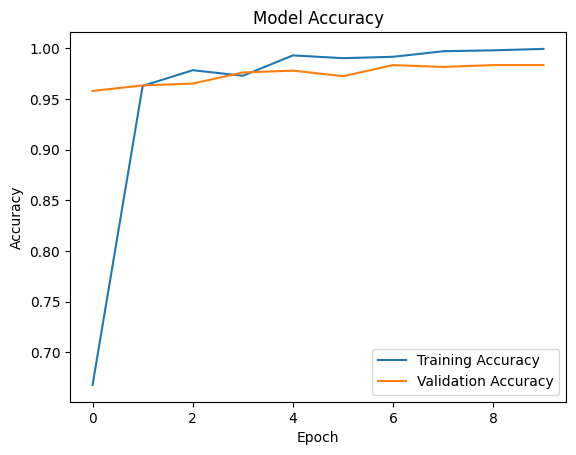

In [25]:
#Model Evaluating Results:



plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [26]:
savepath=r'C:\Users\sachi\231231cxz.h5'

In [27]:
model.save(savepath)

In [28]:
import pickle

In [29]:


word_index = tokenizer.word_index
# Save word_index
with open('word_index2.pkl', 'wb') as file:
    pickle.dump(word_index, file)




In [30]:


config_details = {'max_len': max_len}

# Save configuration details
with open('config_details2.pkl', 'wb') as file:
    pickle.dump(config_details, file)




In [31]:


# Save tokenizer and word index
with open('tokenizer2.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


